<a href="https://colab.research.google.com/github/dariaccc/Jets_CNN/blob/main/Jets_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
#get the dataset
!wget https://zenodo.org/records/3164691/files/QG_jets.npz

#reference for dataset:
#P. T. Komiske, E. M. Metodiev, J. Thaler, Energy Flow Networks:
#Deep Sets for Particle Jets, JHEP 01 (2019) 121, arXiv:1810.05165.

--2025-07-03 08:44:53--  https://zenodo.org/records/3164691/files/QG_jets.npz
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106689379 (102M) [application/octet-stream]
Saving to: ‘QG_jets.npz’

QG_jets.npz         100%[===================>] 101.75M  3.13MB/s    in 50s     

2025-07-03 08:45:43 (2.04 MB/s) - ‘QG_jets.npz’ saved [106689379/106689379]



In [ ]:
import numpy as np #library for multi-dimensional arrays and maths operations on them
import matplotlib.pyplot as plt #for embedding plots and charts
import math #mathematical operations
from sklearn.model_selection import train_test_split #support for dividing the model into train and test
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc #visualisation
import tensorflow as tf #machine learning platform
from tf_keras import layers, models #CNN layers and models
from tf_keras.layers import LeakyReLU #leaky relu (not used - imported for comparison)
from tf_keras.preprocessing.image import ImageDataGenerator #shift images slightly
from tf_keras.callbacks import EarlyStopping #early stopping for the CNN model
import seaborn as sns #visualisation of charts

Loaded jets: (20000, 139, 4) Labels: (20000,)


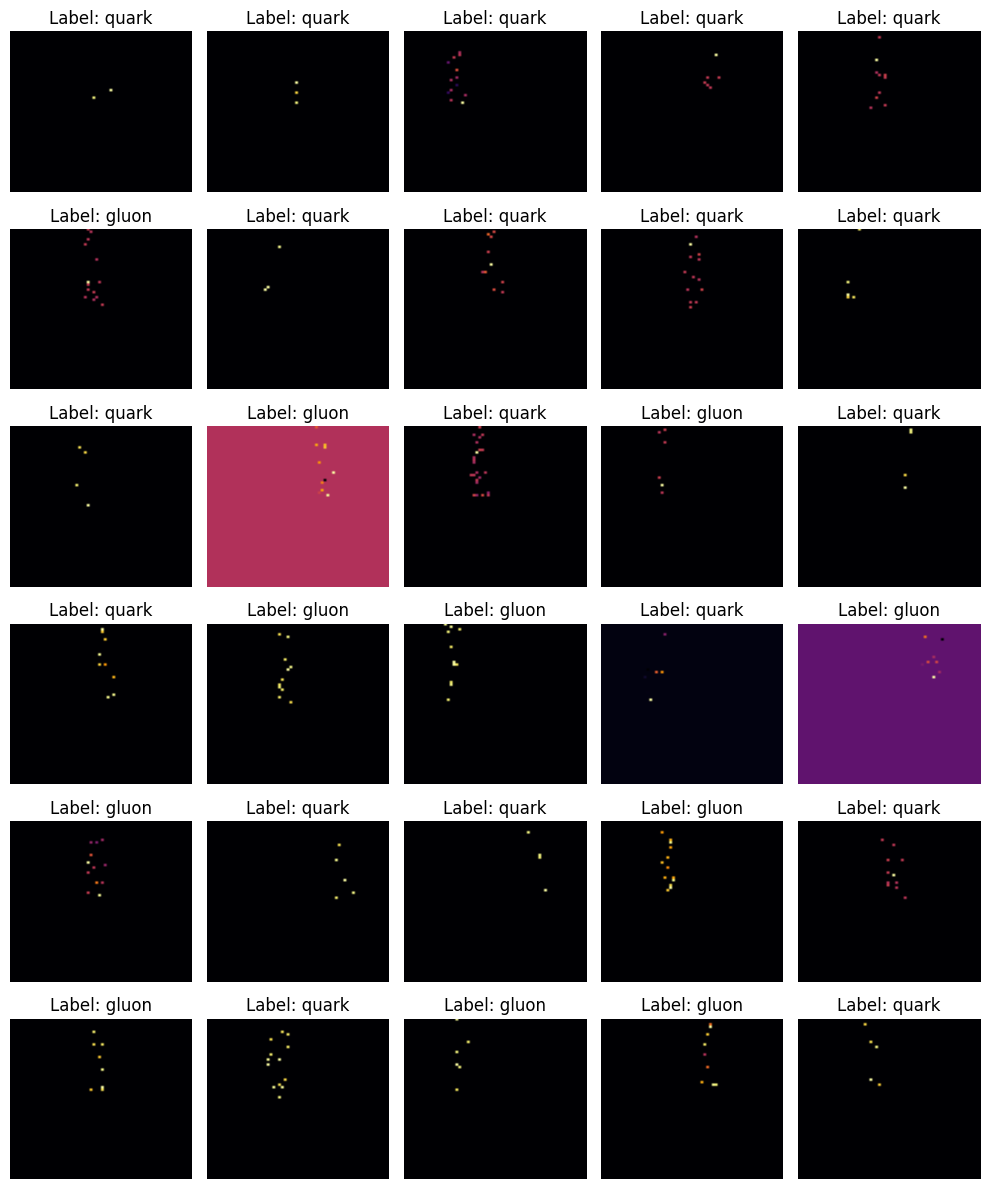

In [ ]:
#load data for the CNN
data = np.load("QG_jets.npz")
X = data['X']
y = data['y']
#to not use too much RAM - load only part of the dataset
X = X[:20000]
y = y[:20000]

print("Loaded jets:", X.shape, "Labels:", y.shape)

#parameters for 2D histogram
px_size = 64 #size for the image
eta_range = (-1.0, 1.0)
phi_range = (-np.pi, np.pi)

#convert the list into an image
def jet_to_image(jet):
    eta = jet[:, 0] #particle angle relative to the beam
    phi = jet[:, 1] #circular angle around the beam
    pt = jet[:, 2] #momentum perpendicular to the beam direction

    H, _, _ = np.histogram2d(eta, phi, bins=px_size, range=[eta_range, phi_range], weights=pt)

    #normalize by total pt to get relative intensity
    if H.sum() > 0:
        H = H / H.sum()
    return H

#visualisation
num_images = 30
images = np.array([jet_to_image(jet) for jet in X])
images = images[..., np.newaxis] #reshape to fit the resnet model

cols = 5  #number of columns
rows = math.ceil(num_images / cols)  #number of rows

fig, axs = plt.subplots(rows, cols, figsize=(10, 2 * rows))

#show the first 30 images for visualisations of the histograms
for i, ax in enumerate(axs.flat):
    if i < num_images:
        #colour map provides colour to the images even though the RGB channel is 1
        ax.imshow(images[i], origin='lower', aspect='auto', cmap='inferno')
        ax.set_title(f"Label: {'quark' if y[i] == 1 else 'gluon'}")
        ax.axis('off')
    else:
        ax.axis('off')  #hide unused axes

plt.tight_layout()
#plt.savefig("quark_gluons.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show()

In [ ]:
#check if the number of quarks and gluons is equal since only a subset of the dataset is loaded
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

{np.float64(0.0): np.int64(9924), np.float64(1.0): np.int64(10076)}


In [ ]:
#split the data into train/test datasets
X_train, X_temp, y_train, y_temp = train_test_split(images, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test     = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

#do the same for the resnet model
X_train_resnet = np.repeat(X_train, 3, axis=-1)
X_val_resnet   = np.repeat(X_val,   3, axis=-1)
X_test_resnet  = np.repeat(X_test,  3, axis=-1)

In [ ]:
#CNN model

model = models.Sequential([ #sequential means the layers follow one another
                           #one input one output, no branching or merging
    layers.Input(shape=(px_size, px_size, 1)),

    #layer 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    #layer 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    #layer 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(), #flatten into 1D to feed to regular layers
    layers.Dense(32, activation='relu'), #fully connected layer

    #dropout rate to reduce overfitting
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  #binary classification - probability result
])

model.compile(optimizer='adam', #optimiser that adjusts the learning rate
                                #(combination of AdaGrad and RMSProp)
              loss='binary_crossentropy', #penalises incorrect predictions
              metrics=['accuracy'])

#datagen = ImageDataGenerator(
 #   horizontal_flip=True  #a very minor image change
#)

#datagen.fit(X_train_resnet)

#early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#history for plotting chart over epochs
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=12,
                    batch_size=128)

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)


Epoch 1/12
110/110 [==============================] - 4s 18ms/step - loss: 0.6680 - accuracy: 0.6084 - val_loss: 0.6470 - val_accuracy: 0.6580
Epoch 2/12
110/110 [==============================] - 2s 15ms/step - loss: 0.6382 - accuracy: 0.6501 - val_loss: 0.6322 - val_accuracy: 0.6547
Epoch 3/12
110/110 [==============================] - 2s 14ms/step - loss: 0.6281 - accuracy: 0.6581 - val_loss: 0.6271 - val_accuracy: 0.6630
Epoch 4/12
110/110 [==============================] - 2s 14ms/step - loss: 0.6278 - accuracy: 0.6579 - val_loss: 0.6241 - val_accuracy: 0.6633
Epoch 5/12
110/110 [==============================] - 2s 15ms/step - loss: 0.6228 - accuracy: 0.6639 - val_loss: 0.6248 - val_accuracy: 0.6567
Epoch 6/12
110/110 [==============================] - 2s 16ms/step - loss: 0.6201 - accuracy: 0.6651 - val_loss: 0.6201 - val_accuracy: 0.6617
Epoch 7/12
110/110 [==============================] - 2s 15ms/step - loss: 0.6138 - accuracy: 0.6674 - val_loss: 0.6233 - val_accuracy: 0.6627

In [ ]:
#import things for the ResNet model that is used for comparison
from tf_keras.applications import ResNet50
from tf_keras.models import Model
from tf_keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, BatchNormalization, Activation
from tf_keras.optimizers import Adam

In [ ]:
#ResNet model

#load base ResNet50 model (exclude top layers)
base_model = ResNet50(weights=None, include_top=False, input_tensor=Input(shape=(px_size, px_size, 3)))

#add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

resnet_model = Model(inputs=base_model.input, outputs=output)

#compile and train
resnet_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history_resnet = resnet_model.fit(X_train_resnet, y_train,
                                  validation_data=(X_val_resnet, y_val),
                                  epochs=10,
                                  batch_size=128)

#evaluate
test_loss, test_acc = resnet_model.evaluate(X_test_resnet, y_test)
print("ResNet Test Accuracy:", test_acc)

Epoch 1/10
110/110 [==============================] - 59s 162ms/step - loss: 0.7768 - accuracy: 0.6411 - val_loss: 0.8542 - val_accuracy: 0.4960
Epoch 2/10
110/110 [==============================] - 15s 134ms/step - loss: 0.6774 - accuracy: 0.6546 - val_loss: 0.8366 - val_accuracy: 0.4960
Epoch 3/10
110/110 [==============================] - 16s 143ms/step - loss: 0.6273 - accuracy: 0.6654 - val_loss: 0.8374 - val_accuracy: 0.4960
Epoch 4/10
110/110 [==============================] - 15s 136ms/step - loss: 0.6284 - accuracy: 0.6739 - val_loss: 0.7095 - val_accuracy: 0.4957
Epoch 5/10
110/110 [==============================] - 15s 136ms/step - loss: 0.6237 - accuracy: 0.6764 - val_loss: 0.7117 - val_accuracy: 0.4950
Epoch 6/10
110/110 [==============================] - 15s 139ms/step - loss: 0.6055 - accuracy: 0.6847 - val_loss: 0.9279 - val_accuracy: 0.5043
Epoch 7/10
110/110 [==============================] - 15s 136ms/step - loss: 0.6065 - accuracy: 0.6830 - val_loss: 1.3504 - val_ac

In [ ]:
#create variables for running the models
preds = model.predict(X_test)
cnn_preds = (preds > 0.5).astype(int).flatten()

resnet_probs = resnet_model.predict(X_test_resnet)  # probs between 0 and 1
resnet_preds = (resnet_probs > 0.5).astype(int).flatten()  # binary labels 0 or 1

94/94 [==============================] - 1s 15ms/step


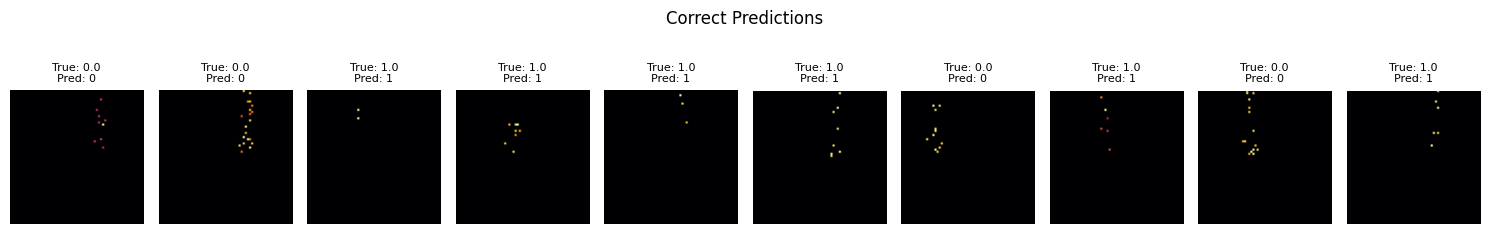

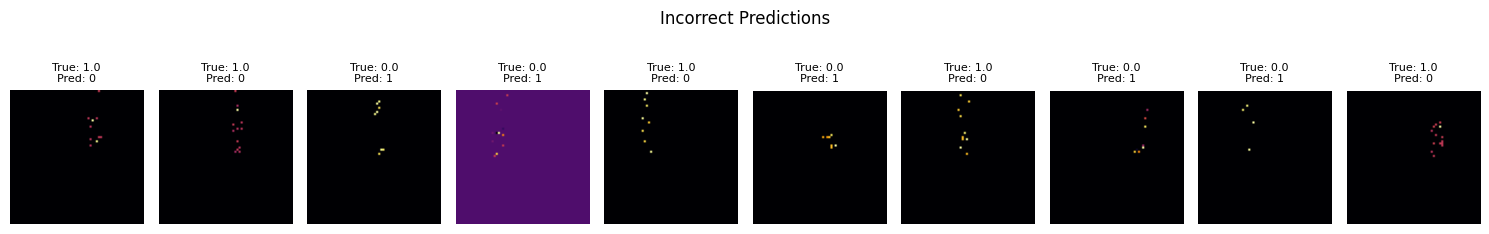

In [ ]:
#visualise correct and incorrect interpretations - 10 examples of each (for CNN)

correct = np.where(cnn_preds == y_test)[0]
wrong = np.where(cnn_preds != y_test)[0]

def plot_examples(indices, title):
    plt.figure(figsize=(15, 2))
    for i, idx in enumerate(indices[:10]):
        plt.subplot(1, 10, i+1)
        plt.imshow(X_test[idx].squeeze(), cmap='inferno', origin='lower')
        plt.title(f"True: {y_test[idx]}\nPred: {cnn_preds[idx]}", fontsize=8)
        plt.axis('off')
    plt.suptitle(title, y=1.15)
    plt.tight_layout()
    plt.subplots_adjust(top=0.75)
    plt.show()

plot_examples(correct, "Correct Predictions")
plot_examples(wrong, "Incorrect Predictions")


In [ ]:
#classification report for the CNN model
print("Accuracy:", accuracy_score(y_test, cnn_preds))
print("\nClassification Report:")
print(classification_report(y_test, cnn_preds, target_names=["Gluon", "Quark"]))

Accuracy: 0.682

Classification Report:
              precision    recall  f1-score   support

       Gluon       0.69      0.66      0.67      1489
       Quark       0.68      0.70      0.69      1511

    accuracy                           0.68      3000
   macro avg       0.68      0.68      0.68      3000
weighted avg       0.68      0.68      0.68      3000



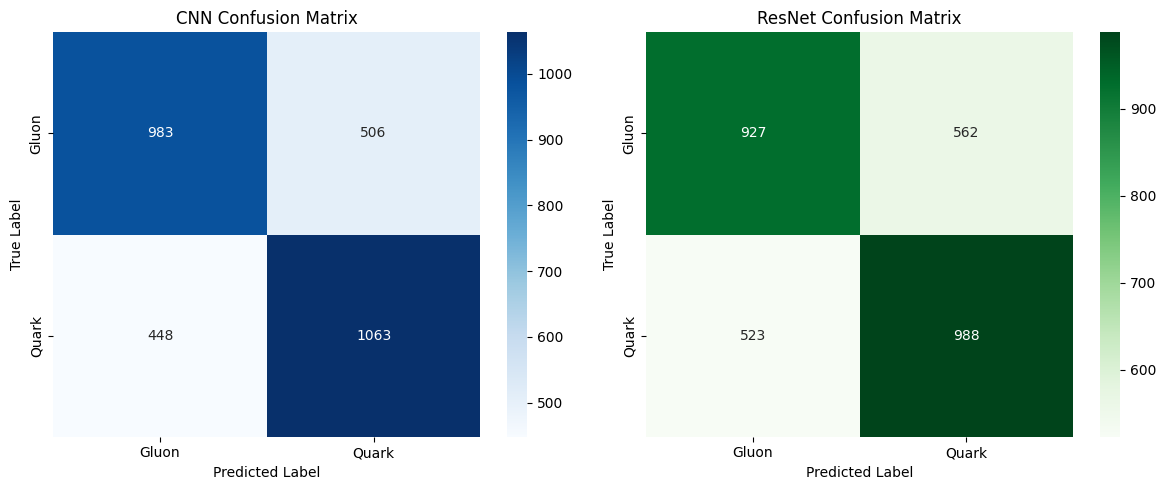

In [ ]:
#confusion matrices of both CNN and ResNet for comparison
cm_cnn = confusion_matrix(y_test, cnn_preds)
cm_resnet = confusion_matrix(y_test, resnet_preds)

#plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues", xticklabels=["Gluon", "Quark"],
            yticklabels=["Gluon", "Quark"], ax=axs[0])
axs[0].set_title("CNN Confusion Matrix")
axs[0].set_xlabel("Predicted Label")
axs[0].set_ylabel("True Label")

sns.heatmap(cm_resnet, annot=True, fmt="d", cmap="Greens", xticklabels=["Gluon", "Quark"],
            yticklabels=["Gluon", "Quark"], ax=axs[1])
axs[1].set_title("ResNet Confusion Matrix")
axs[1].set_xlabel("Predicted Label")
axs[1].set_ylabel("True Label")

plt.tight_layout()

#plt.savefig("CF_matrix.pdf", bbox_inches='tight', pad_inches=0.01)

plt.show()

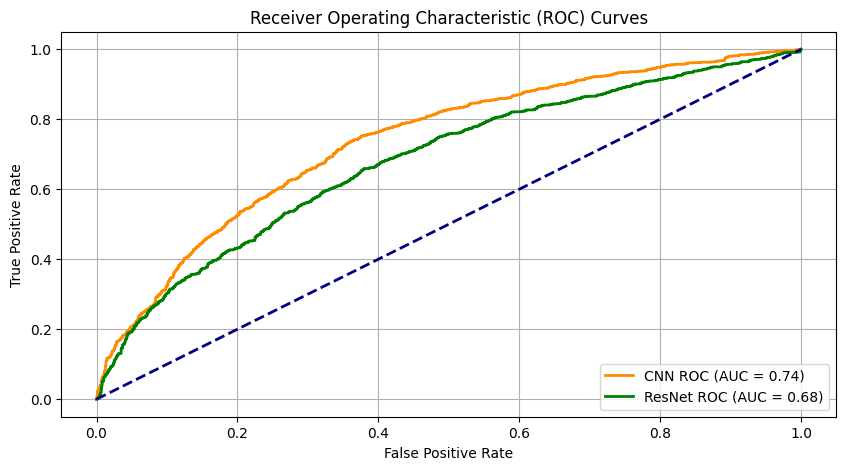

In [ ]:
# CNN ROC
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, preds)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

# ResNet ROC
fpr_resnet, tpr_resnet, _ = roc_curve(y_test, resnet_probs)
roc_auc_resnet = auc(fpr_resnet, tpr_resnet)

plt.figure(figsize=(10, 5))

# CNN ROC curve
plt.plot(fpr_cnn, tpr_cnn, color='darkorange', lw=2, label=f"CNN ROC (AUC = {roc_auc_cnn:.2f})")

# ResNet ROC curve
plt.plot(fpr_resnet, tpr_resnet, color='green', lw=2, label=f"ResNet ROC (AUC = {roc_auc_resnet:.2f})")

# Diagonal line (random guess)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curves")
plt.legend(loc="lower right")
plt.grid(True)

#plt.savefig("ROC.pdf", bbox_inches='tight', pad_inches=0.01)

plt.show()

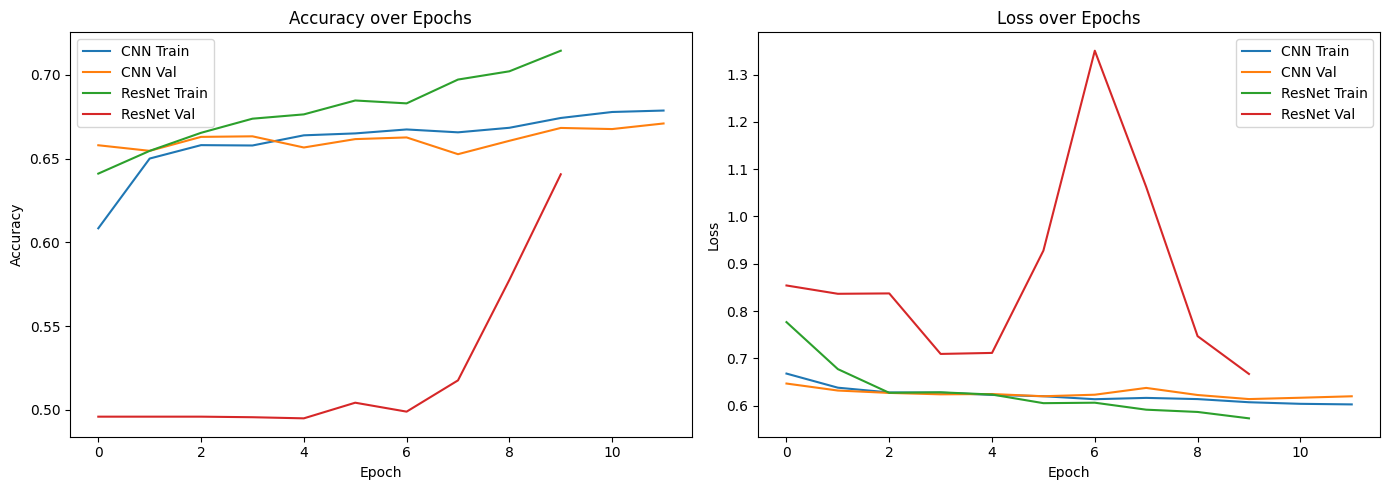

In [ ]:
#curves for loss and accuracy
plt.figure(figsize=(14, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="CNN Train")
plt.plot(history.history['val_accuracy'], label="CNN Val")
plt.plot(history_resnet.history['accuracy'], label="ResNet Train")
plt.plot(history_resnet.history['val_accuracy'], label="ResNet Val")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="CNN Train")
plt.plot(history.history['val_loss'], label="CNN Val")
plt.plot(history_resnet.history['loss'], label="ResNet Train")
plt.plot(history_resnet.history['val_loss'], label="ResNet Val")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
#plt.savefig("train_vs_val.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show()
